In [18]:
"""
Perform empirical analysis for equations on MMRZ paper.
Equation (13) and (17) are treated.
"""
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
load_dotenv()

DEX = "SUSHI"
PAIR = "USDC_WETH"

# generate DataFrame from csv
blocks_df = pd.read_csv("data/blocks/timestamp_blockNumber_baseFeePerGas.csv")
cex_prices_df = pd.read_csv("data/cex_price/ETHUSDC-1s-2023-10-opens.csv")
syncs_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_syncs.csv")
    .drop_duplicates(subset="blockNumber", keep="last")
    .reset_index(drop=True)
)  # take the last values of each block
swaps_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_swaps.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the swaps in block
mints_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_mints.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the mints in block
burns_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_burns.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the burns in block

# divide the amounts by 10**decimals
# beware of the token numbers!
syncs_df["reserve0"] /= 10**6
syncs_df["reserve1"] /= 10**18

swaps_df["amount0In"] /= 10**6
swaps_df["amount0Out"] /= 10**6
swaps_df["amount1In"] /= 10**18
swaps_df["amount1Out"] /= 10**18

mints_df["amount0Minted"] /= 10**6
mints_df["amount1Minted"] /= 10**18

burns_df["amount0Burnt"] /= 10**6
burns_df["amount1Burnt"] /= 10**18

# construct the main df
df = blocks_df
df = pd.merge(df, cex_prices_df, on="timestamp", how="left")
df = pd.merge(df, syncs_df, on="blockNumber", how="left")
df = pd.merge(df, swaps_df, on="blockNumber", how="left")
df = pd.merge(df, mints_df, on="blockNumber", how="left")
df = pd.merge(df, burns_df, on="blockNumber", how="left")
df.fillna(0.0, inplace=True)
for i in range(1, len(df)):
    if df.at[i, "reserve0"] == 0.0:
        df.at[i, "reserve0"] = df.at[i - 1, "reserve0"]
    if df.at[i, "reserve1"] == 0.0:
        df.at[i, "reserve1"] = df.at[i - 1, "reserve1"]

In [20]:
"""
We compute the components for decomposition of LP PnL.
"""
# The Left Hand Side of equation (13)
df["mintValue"] = df["amount0Minted"] + df["amount1Minted"] * df["price"]
df["burnValue"] = df["amount0Burnt"] + df["amount1Burnt"] * df["price"]
df["poolValue"] = df["reserve0"] + df["reserve1"] * df["price"]
df["poolPnL"] = (
    df["poolValue"] + df["burnValue"] - df["mintValue"] - df["poolValue"].shift(1)
)

# The Middle Hand Side of equation (13)
df["feeEarned"] = 0.003 * (df["amount0In"] + df["amount1In"] * df["price"])
df["poolPnLWithoutFee"] = df["poolPnL"] - df["feeEarned"]

# The Right Hand Side of equation (13)
df["rebalancingStrategyPnL"] = df["reserve1"].shift(1) * (
    df["price"] - df["price"].shift(1)
)  # market risk = rebalancing strategy PnL
# fee is already computed
df["traderPnL"] = (df["amount0Out"] + df["amount1Out"] * df["price"]) - (
    df["amount0In"] + df["amount1In"] * df["price"]
) * 0.997  # 0.3% of input is deducted as fee, so it should not be considered.
df["LVR"] = df[
    "traderPnL"
]  # LVR is equal to Arbitrageur's profit under the zero-fee assumption

In [21]:
# Calculate cumulative sums
df["cum_poolPnL"] = df["poolPnL"].cumsum()
df["cum_feeEarned"] = df["feeEarned"].cumsum()
df["cum_poolPnLWithoutFee"] = df["poolPnLWithoutFee"].cumsum()
df["cum_rebalancingStrategyPnL"] = df["rebalancingStrategyPnL"].cumsum()
df["cum_traderPnL"] = df["traderPnL"].cumsum()
df["cum_LVR"] = df["LVR"].cumsum()

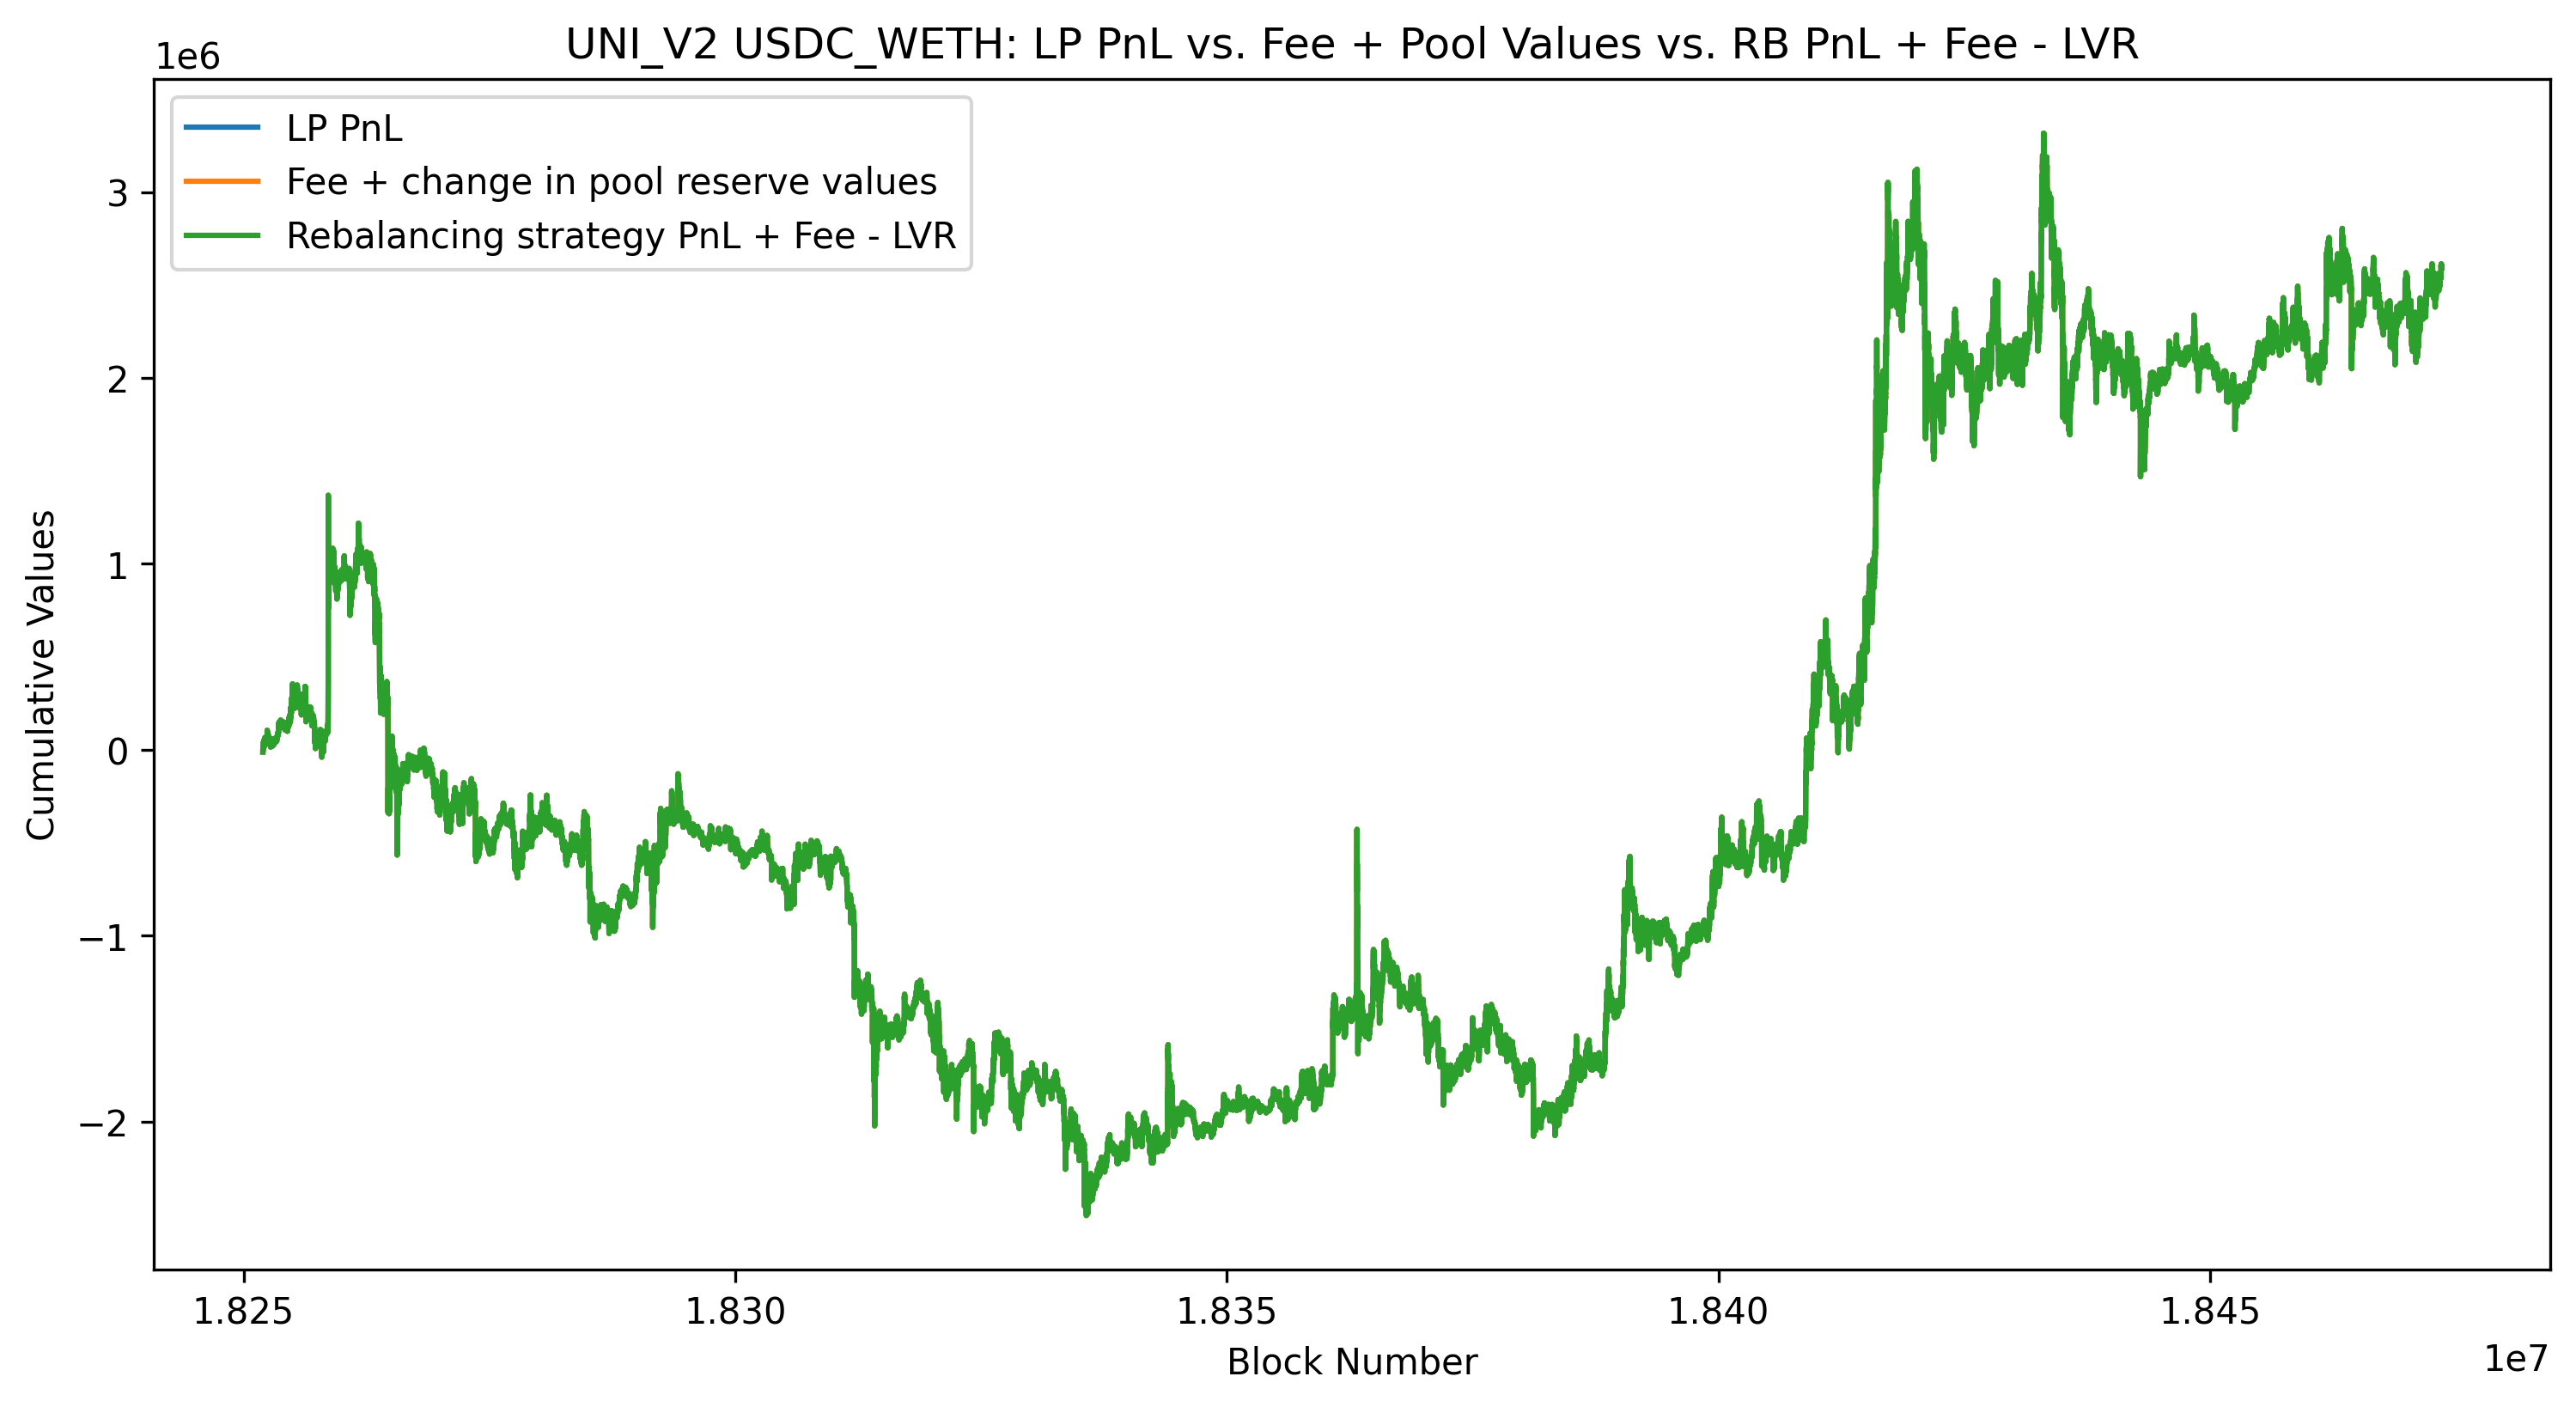

In [22]:
"""
Plot each cumulative term of equation (13)
"""
plt.figure(figsize=(12, 6), dpi=300)

plt.plot(
    df["blockNumber"],
    df["cum_poolPnL"],
    label="LP PnL",
)
plt.plot(
    df["blockNumber"],
    df["cum_feeEarned"] + df["cum_poolPnLWithoutFee"],
    label="Fee + change in pool reserve values",
)
plt.plot(
    df["blockNumber"],
    df["cum_rebalancingStrategyPnL"] + df["cum_feeEarned"] - df["cum_LVR"],
    label="Rebalancing strategy PnL + Fee - LVR",
)

plt.xlabel("Block Number")
plt.ylabel("Cumulative Values")
plt.title(f"{DEX} {PAIR}: LP PnL vs. Fee + Pool Values vs. RB PnL + Fee - LVR")
plt.legend()

plt.show()

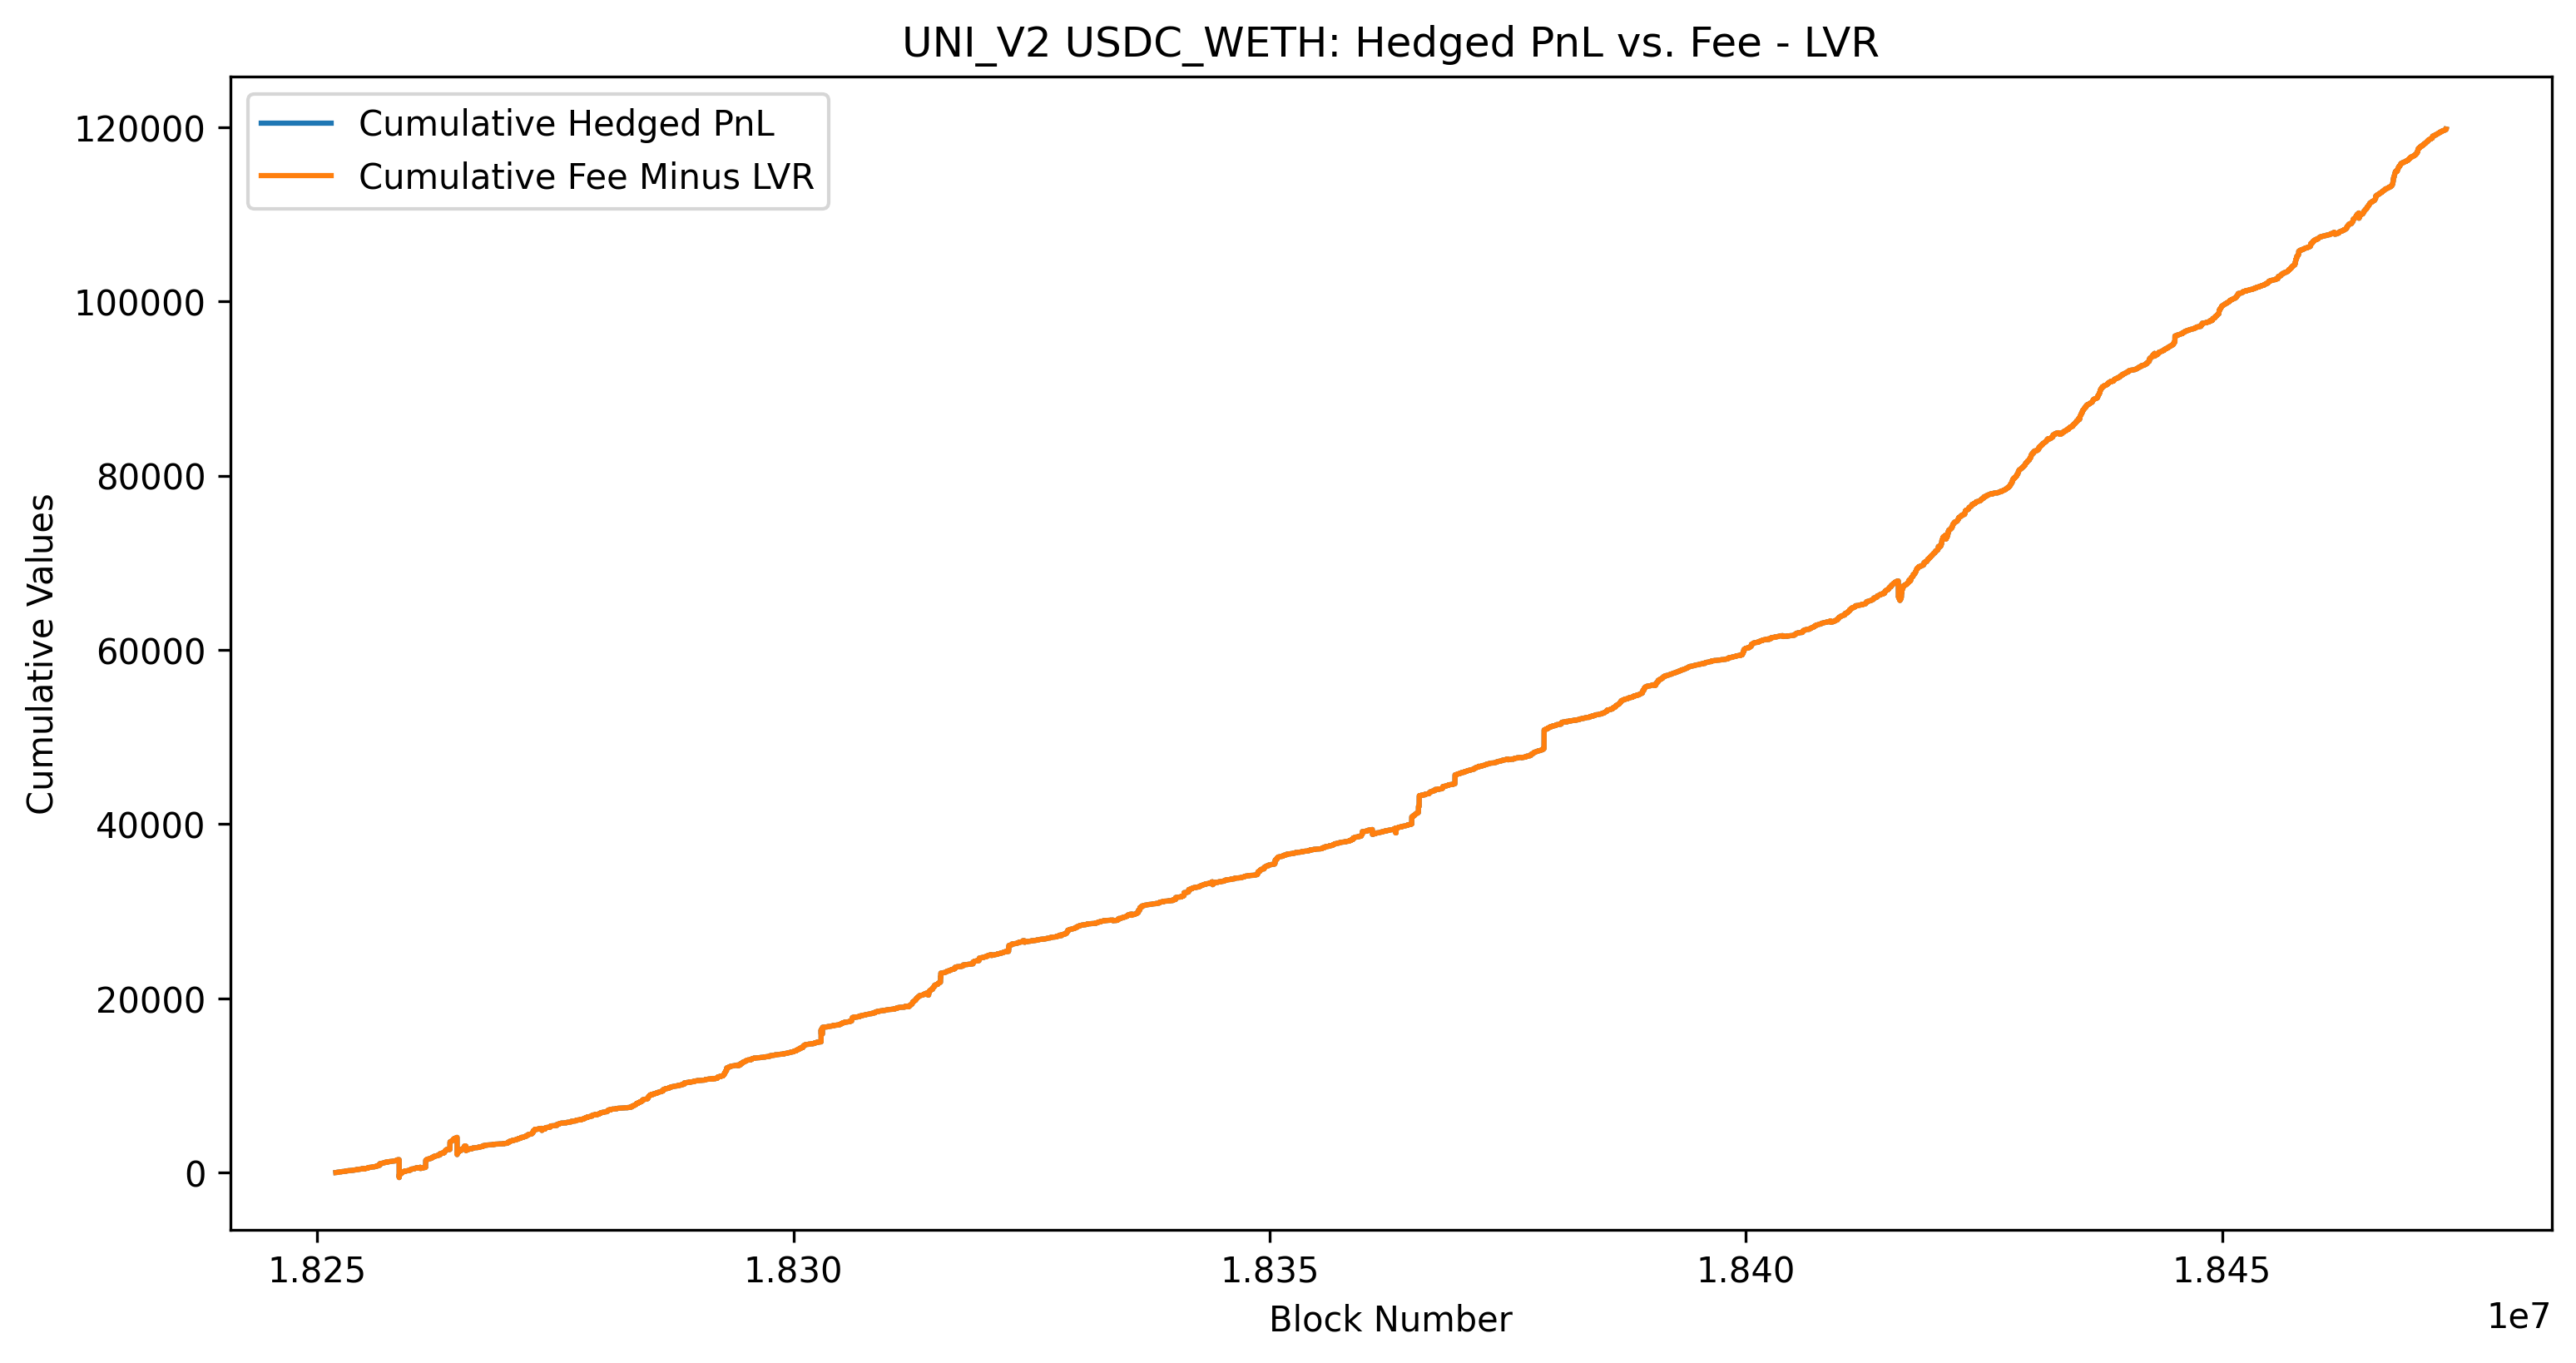

In [23]:
"""
Plot each cumulative term of equation (17)
"""
plt.figure(figsize=(12, 6), dpi=300)

plt.plot(
    df["blockNumber"],
    df["cum_poolPnL"] - df["cum_rebalancingStrategyPnL"],
    label="Cumulative Hedged PnL",
)
plt.plot(
    df["blockNumber"],
    df["cum_feeEarned"] - df["cum_LVR"],
    label="Cumulative Fee Minus LVR",
)

plt.xlabel("Block Number")
plt.ylabel("Cumulative Values")
plt.title(f"{DEX} {PAIR}: Hedged PnL vs. Fee - LVR")
plt.legend()

plt.show()

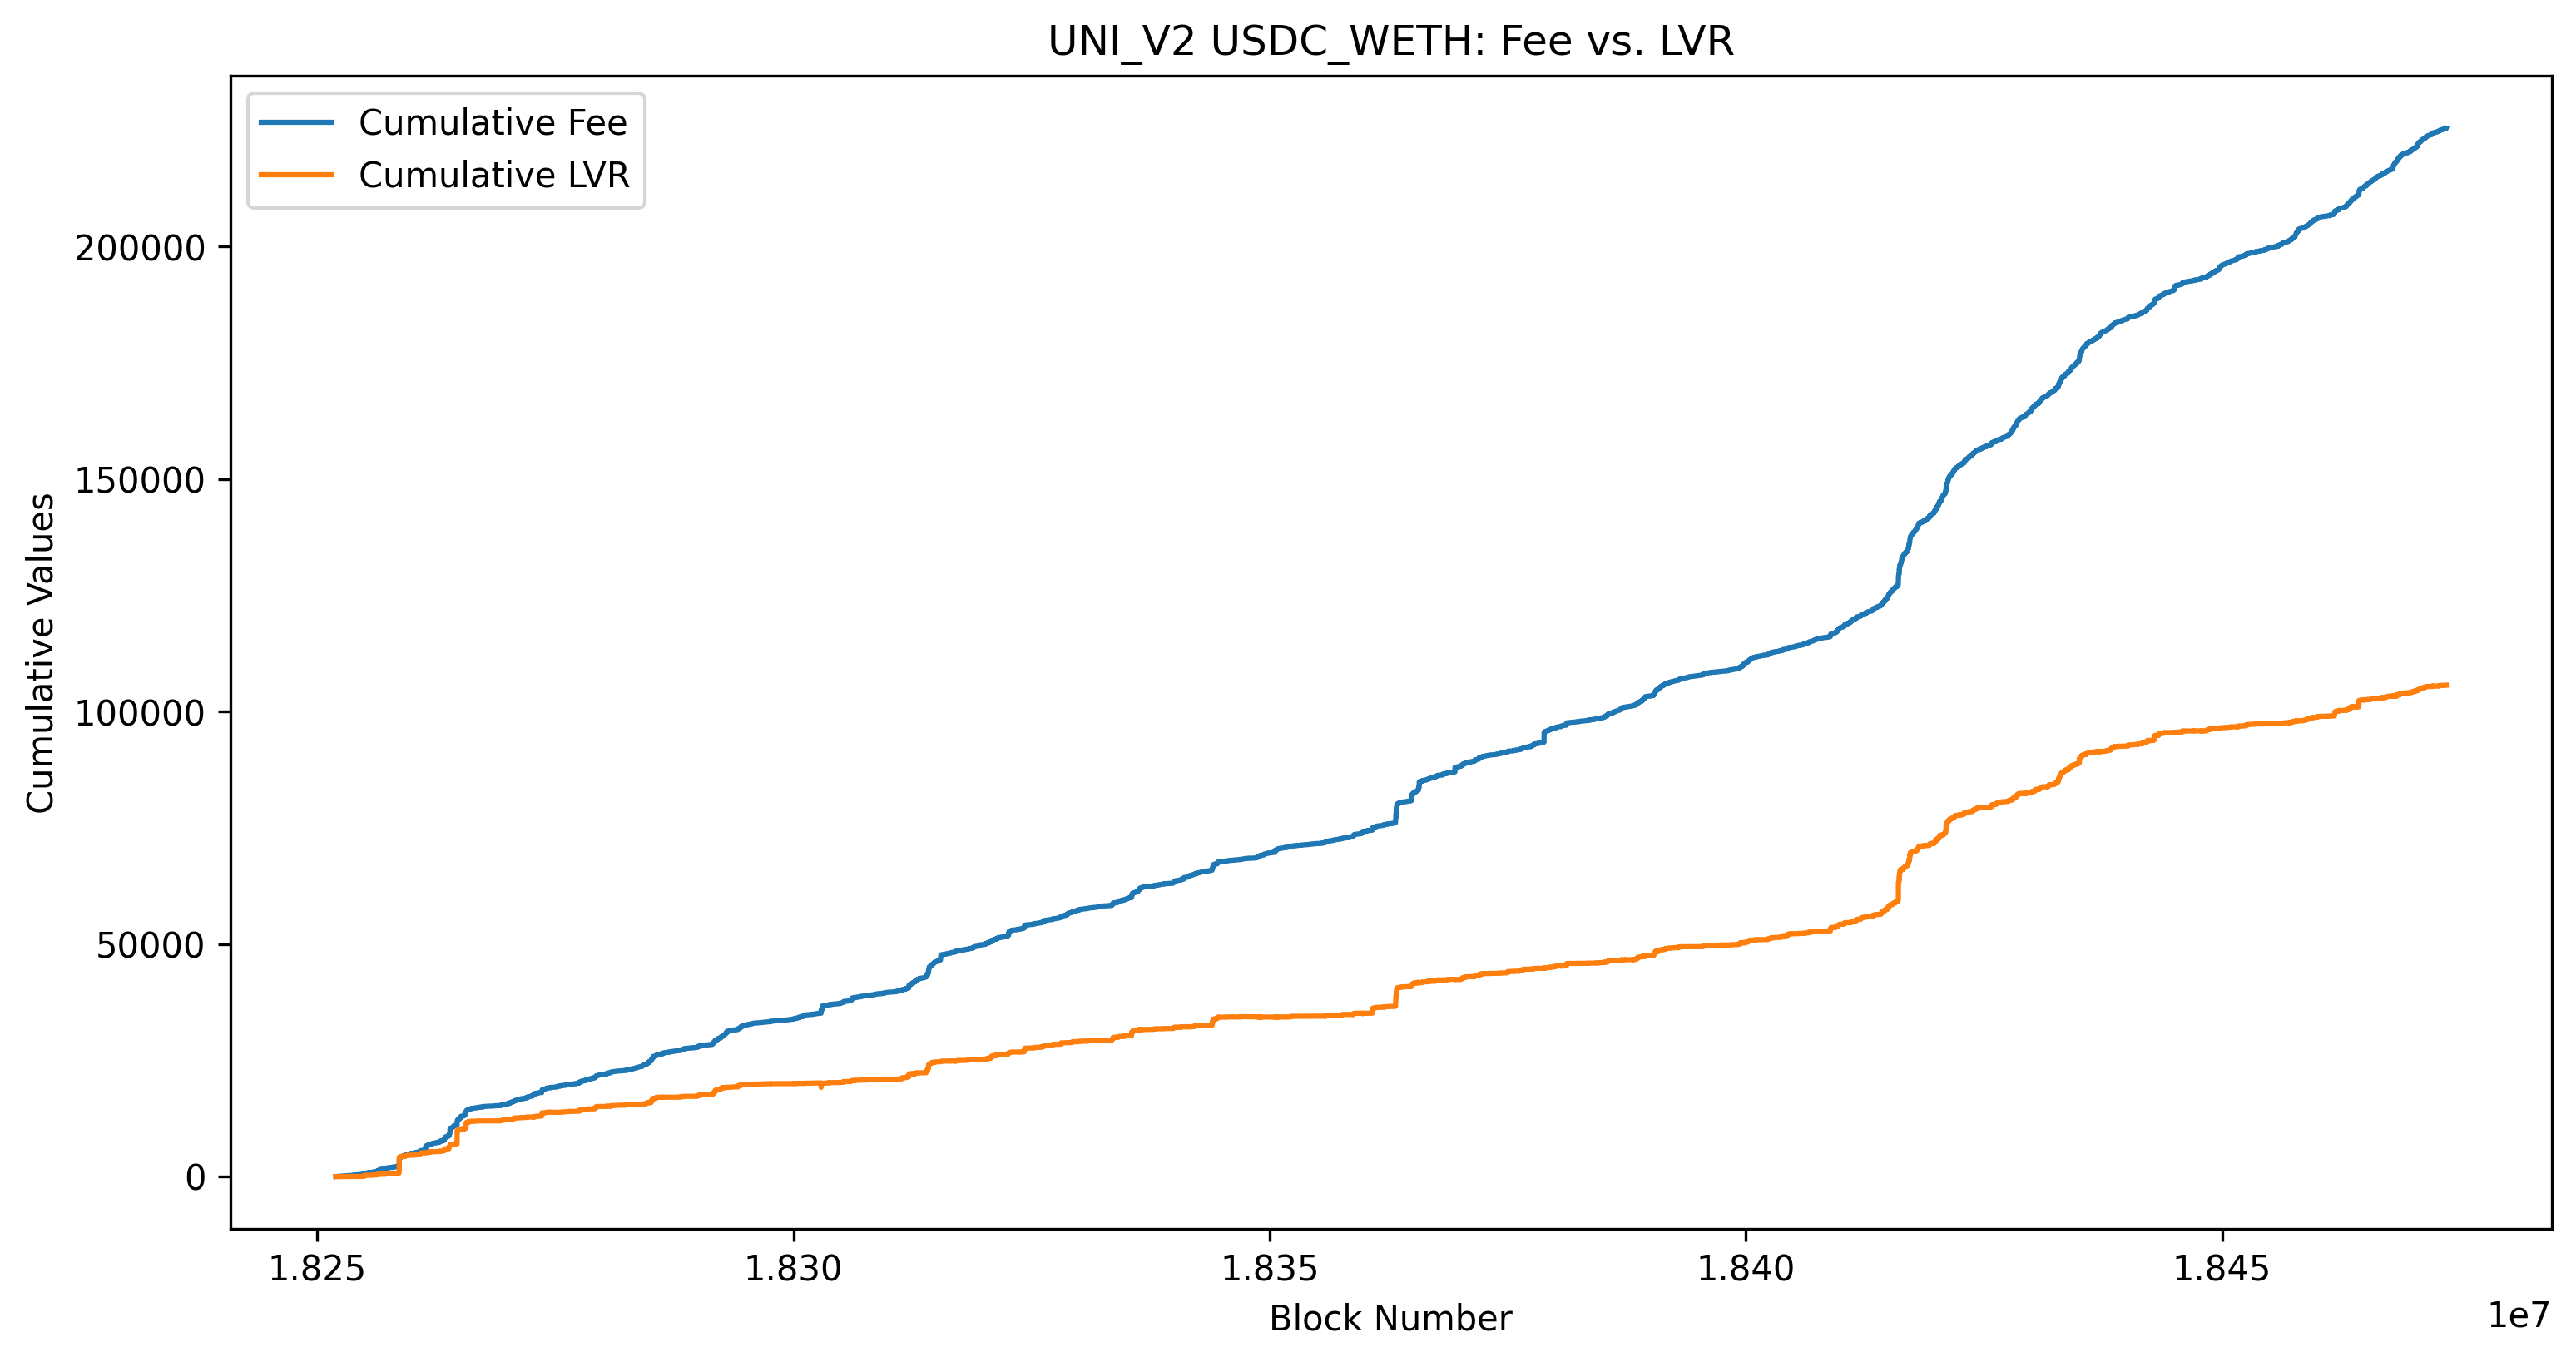

In [24]:
"""
Fee & LVR
"""
plt.figure(figsize=(12, 6), dpi=300)

plt.plot(
    df["blockNumber"],
    df["cum_feeEarned"],
    label="Cumulative Fee",
)
plt.plot(
    df["blockNumber"],
    df["cum_LVR"],
    label="Cumulative LVR",
)

plt.xlabel("Block Number")
plt.ylabel("Cumulative Values")
plt.title(f"{DEX} {PAIR}: Fee vs. LVR")
plt.legend()

plt.show()

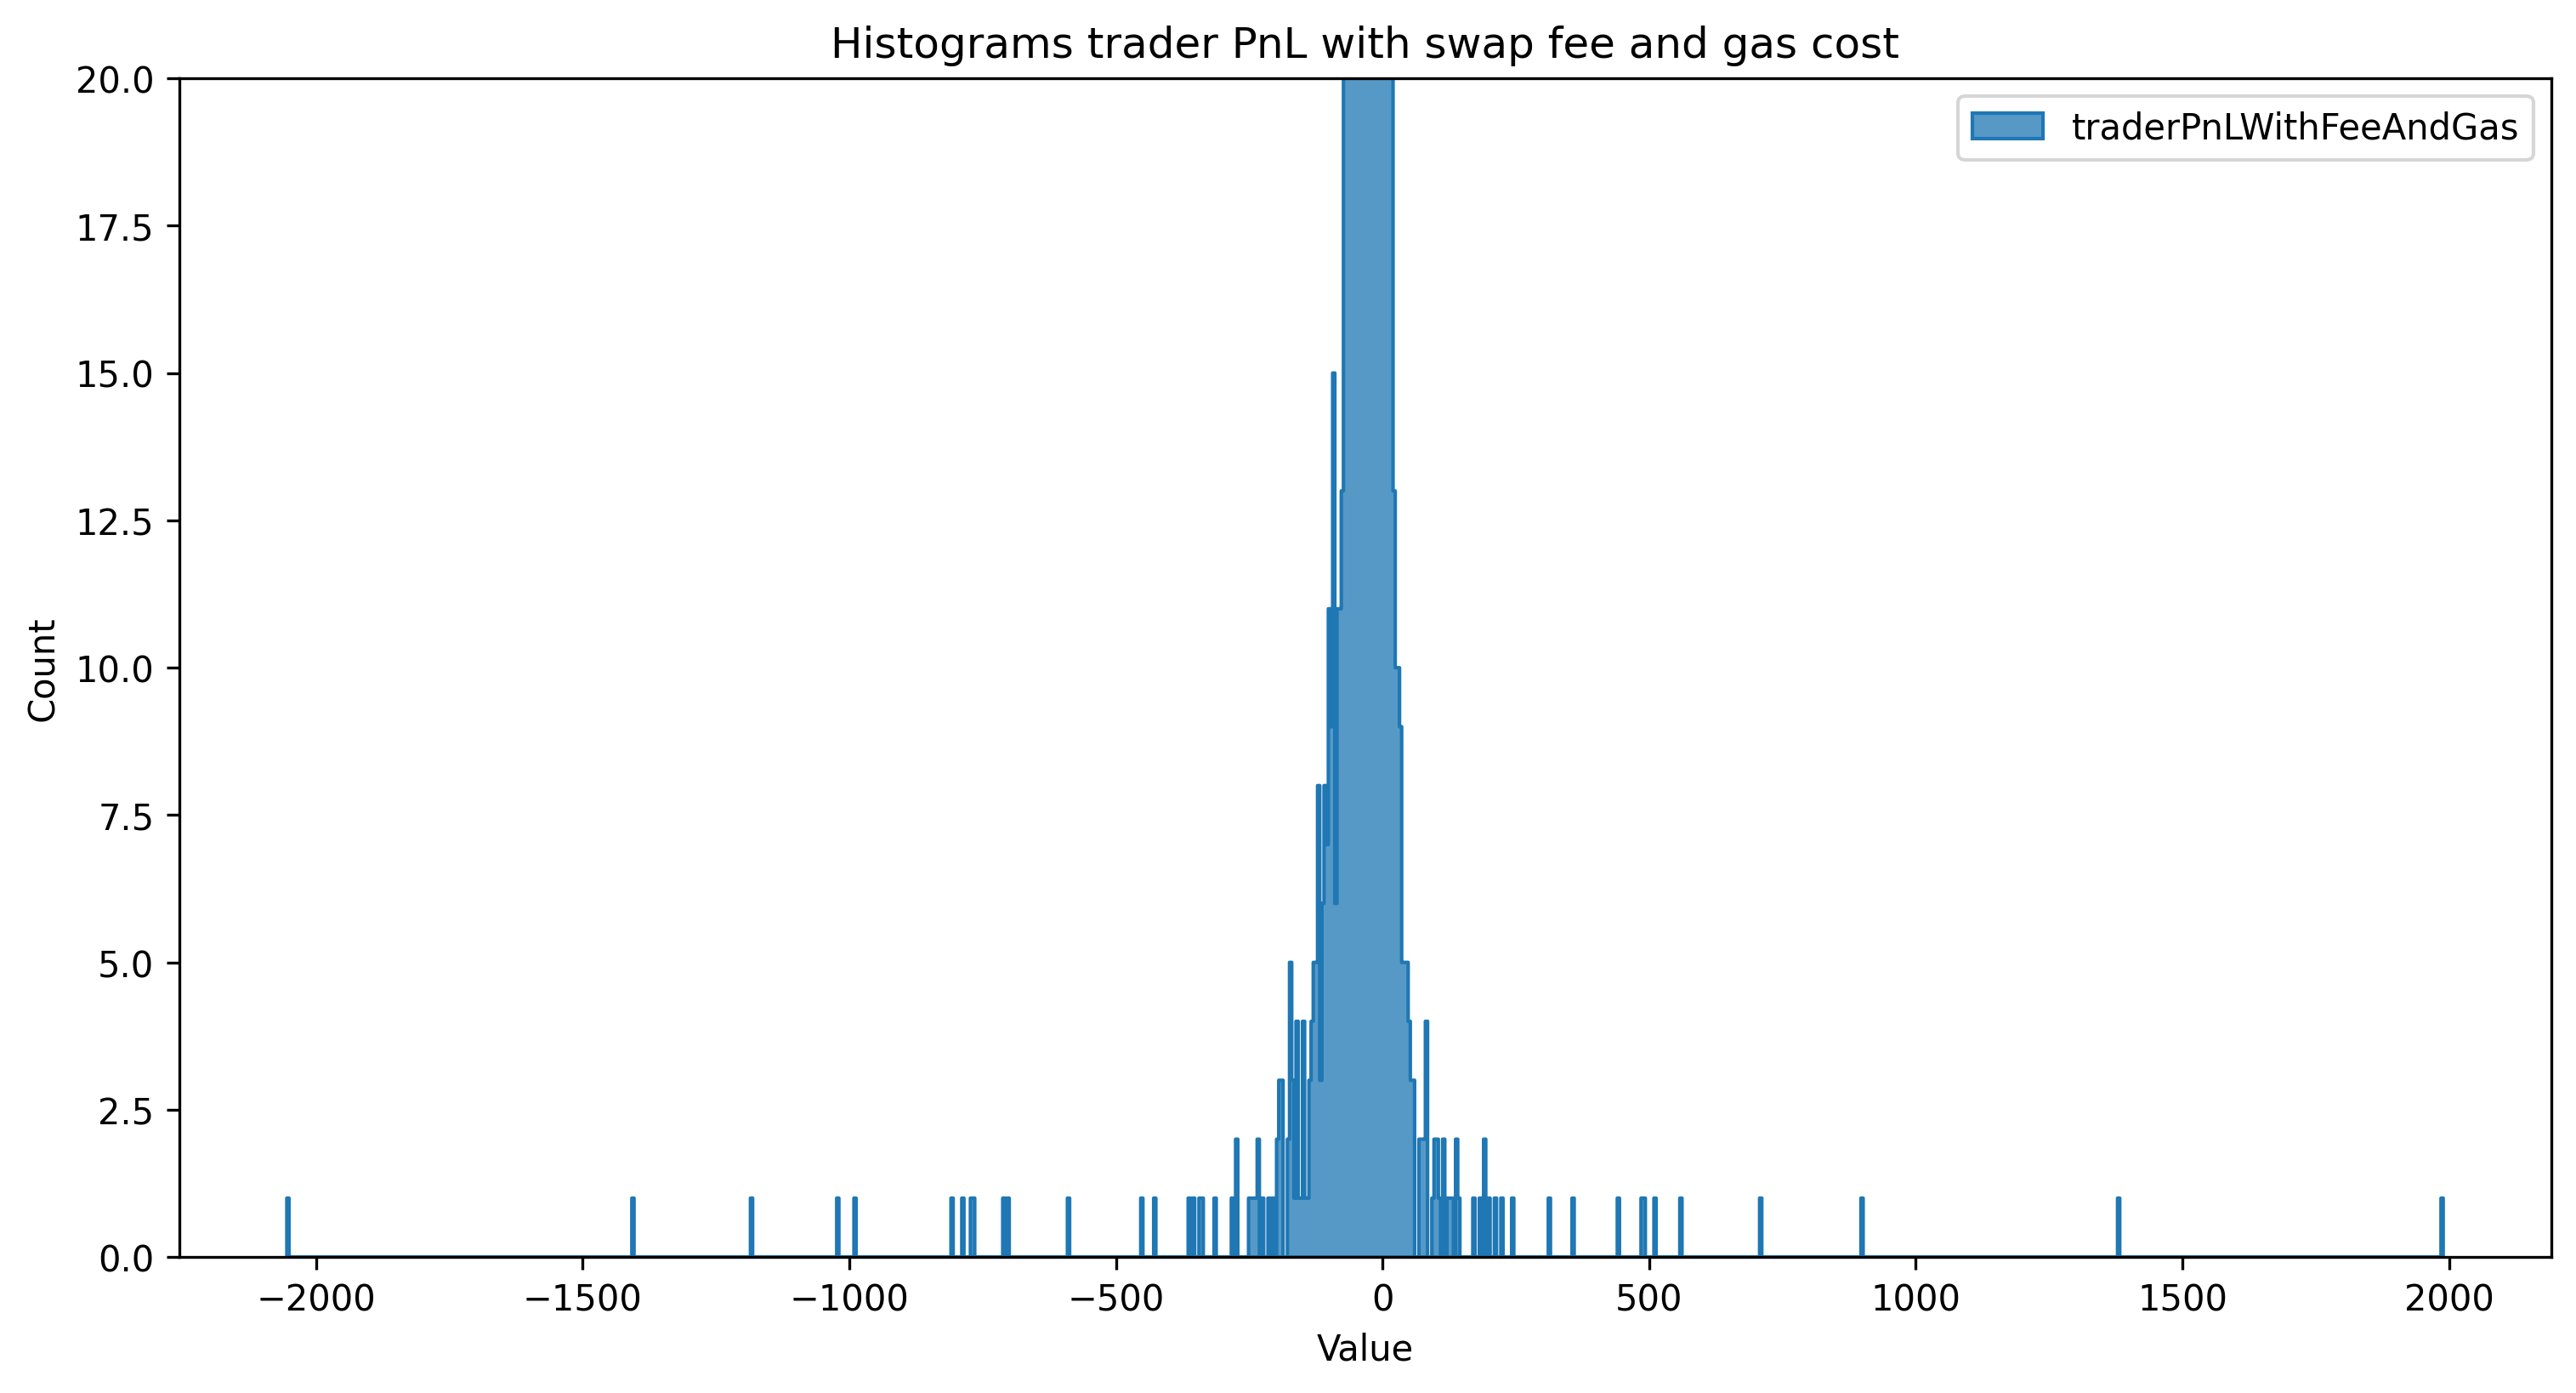

In [25]:
"""
Trader profit distribution including swap fee and gas cost.
140000 is median of gas usage on V2 swap.
"""
df["traderPnLWithFeeAndGas"] = (
    df["traderPnL"]
    - df["feeEarned"]
    - 140000 * df["baseFeePerGas"] * df["price"] / 10**18
)
blocks_with_trades = df[df["feeEarned"] > 0.03]  # only trades with size > $10

plt.figure(figsize=(12, 6), dpi=300)
sns.histplot(
    blocks_with_trades["traderPnLWithFeeAndGas"],
    bins=1000,
    label="traderPnLWithFeeAndGas",
    element="step",
)
plt.ylim(0, 20)

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histograms trader PnL with swap fee and gas cost")
plt.legend()

plt.show()

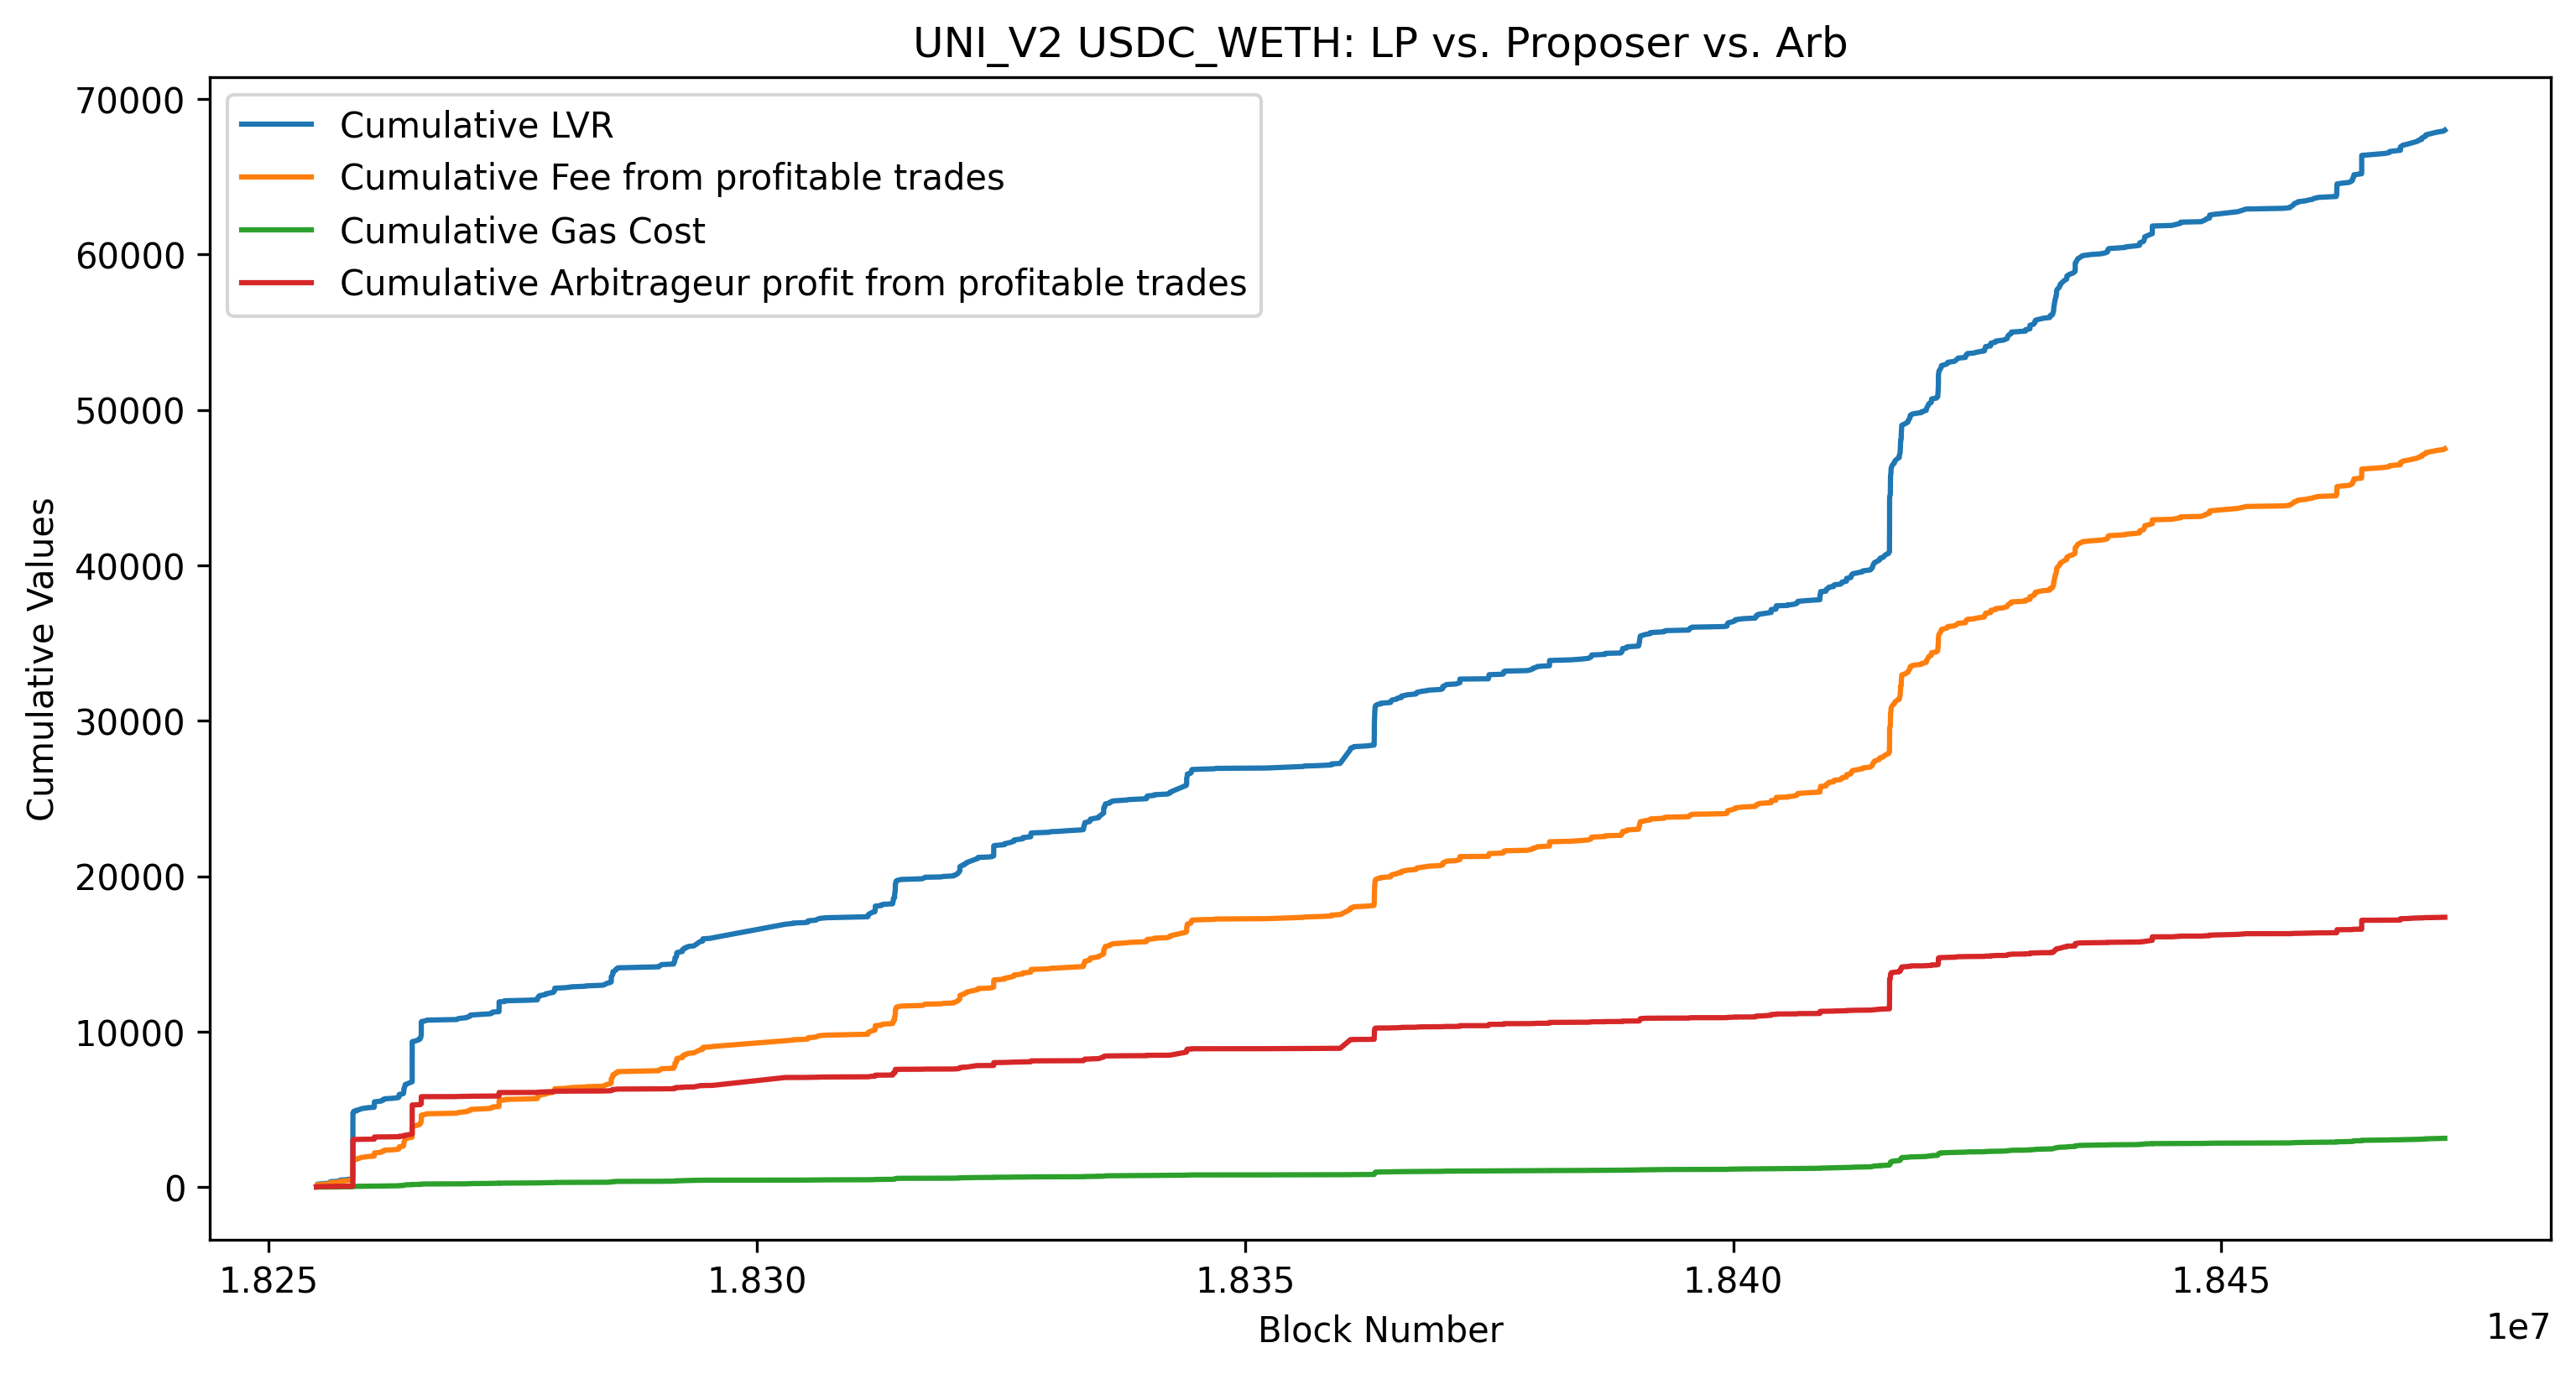

In [32]:
"""
Accumulated LVR Distribution: between LP, Block Proposer, and Arbitrageur
"""
profitable_trades = df[df["traderPnLWithFeeAndGas"] > 0]


plt.figure(figsize=(12, 6), dpi=300)

plt.plot(
    profitable_trades["blockNumber"],
    profitable_trades["LVR"].cumsum(),
    label="Cumulative LVR",
)
plt.plot(
    profitable_trades["blockNumber"],
    profitable_trades["feeEarned"].cumsum(),
    label="Cumulative Fee from profitable trades",
)
plt.plot(
    profitable_trades["blockNumber"],
    (
        profitable_trades["price"]
        * 140000
        * profitable_trades["baseFeePerGas"]
        / 10**18
    ).cumsum(),
    label="Cumulative Gas Cost",
)
plt.plot(
    profitable_trades["blockNumber"],
    profitable_trades["traderPnLWithFeeAndGas"].cumsum(),
    label="Cumulative Arbitrageur profit from profitable trades",
)

plt.xlabel("Block Number")
plt.ylabel("Cumulative Values")
plt.title(f"{DEX} {PAIR}: LP vs. Proposer vs. Arb")
plt.legend()

plt.show()

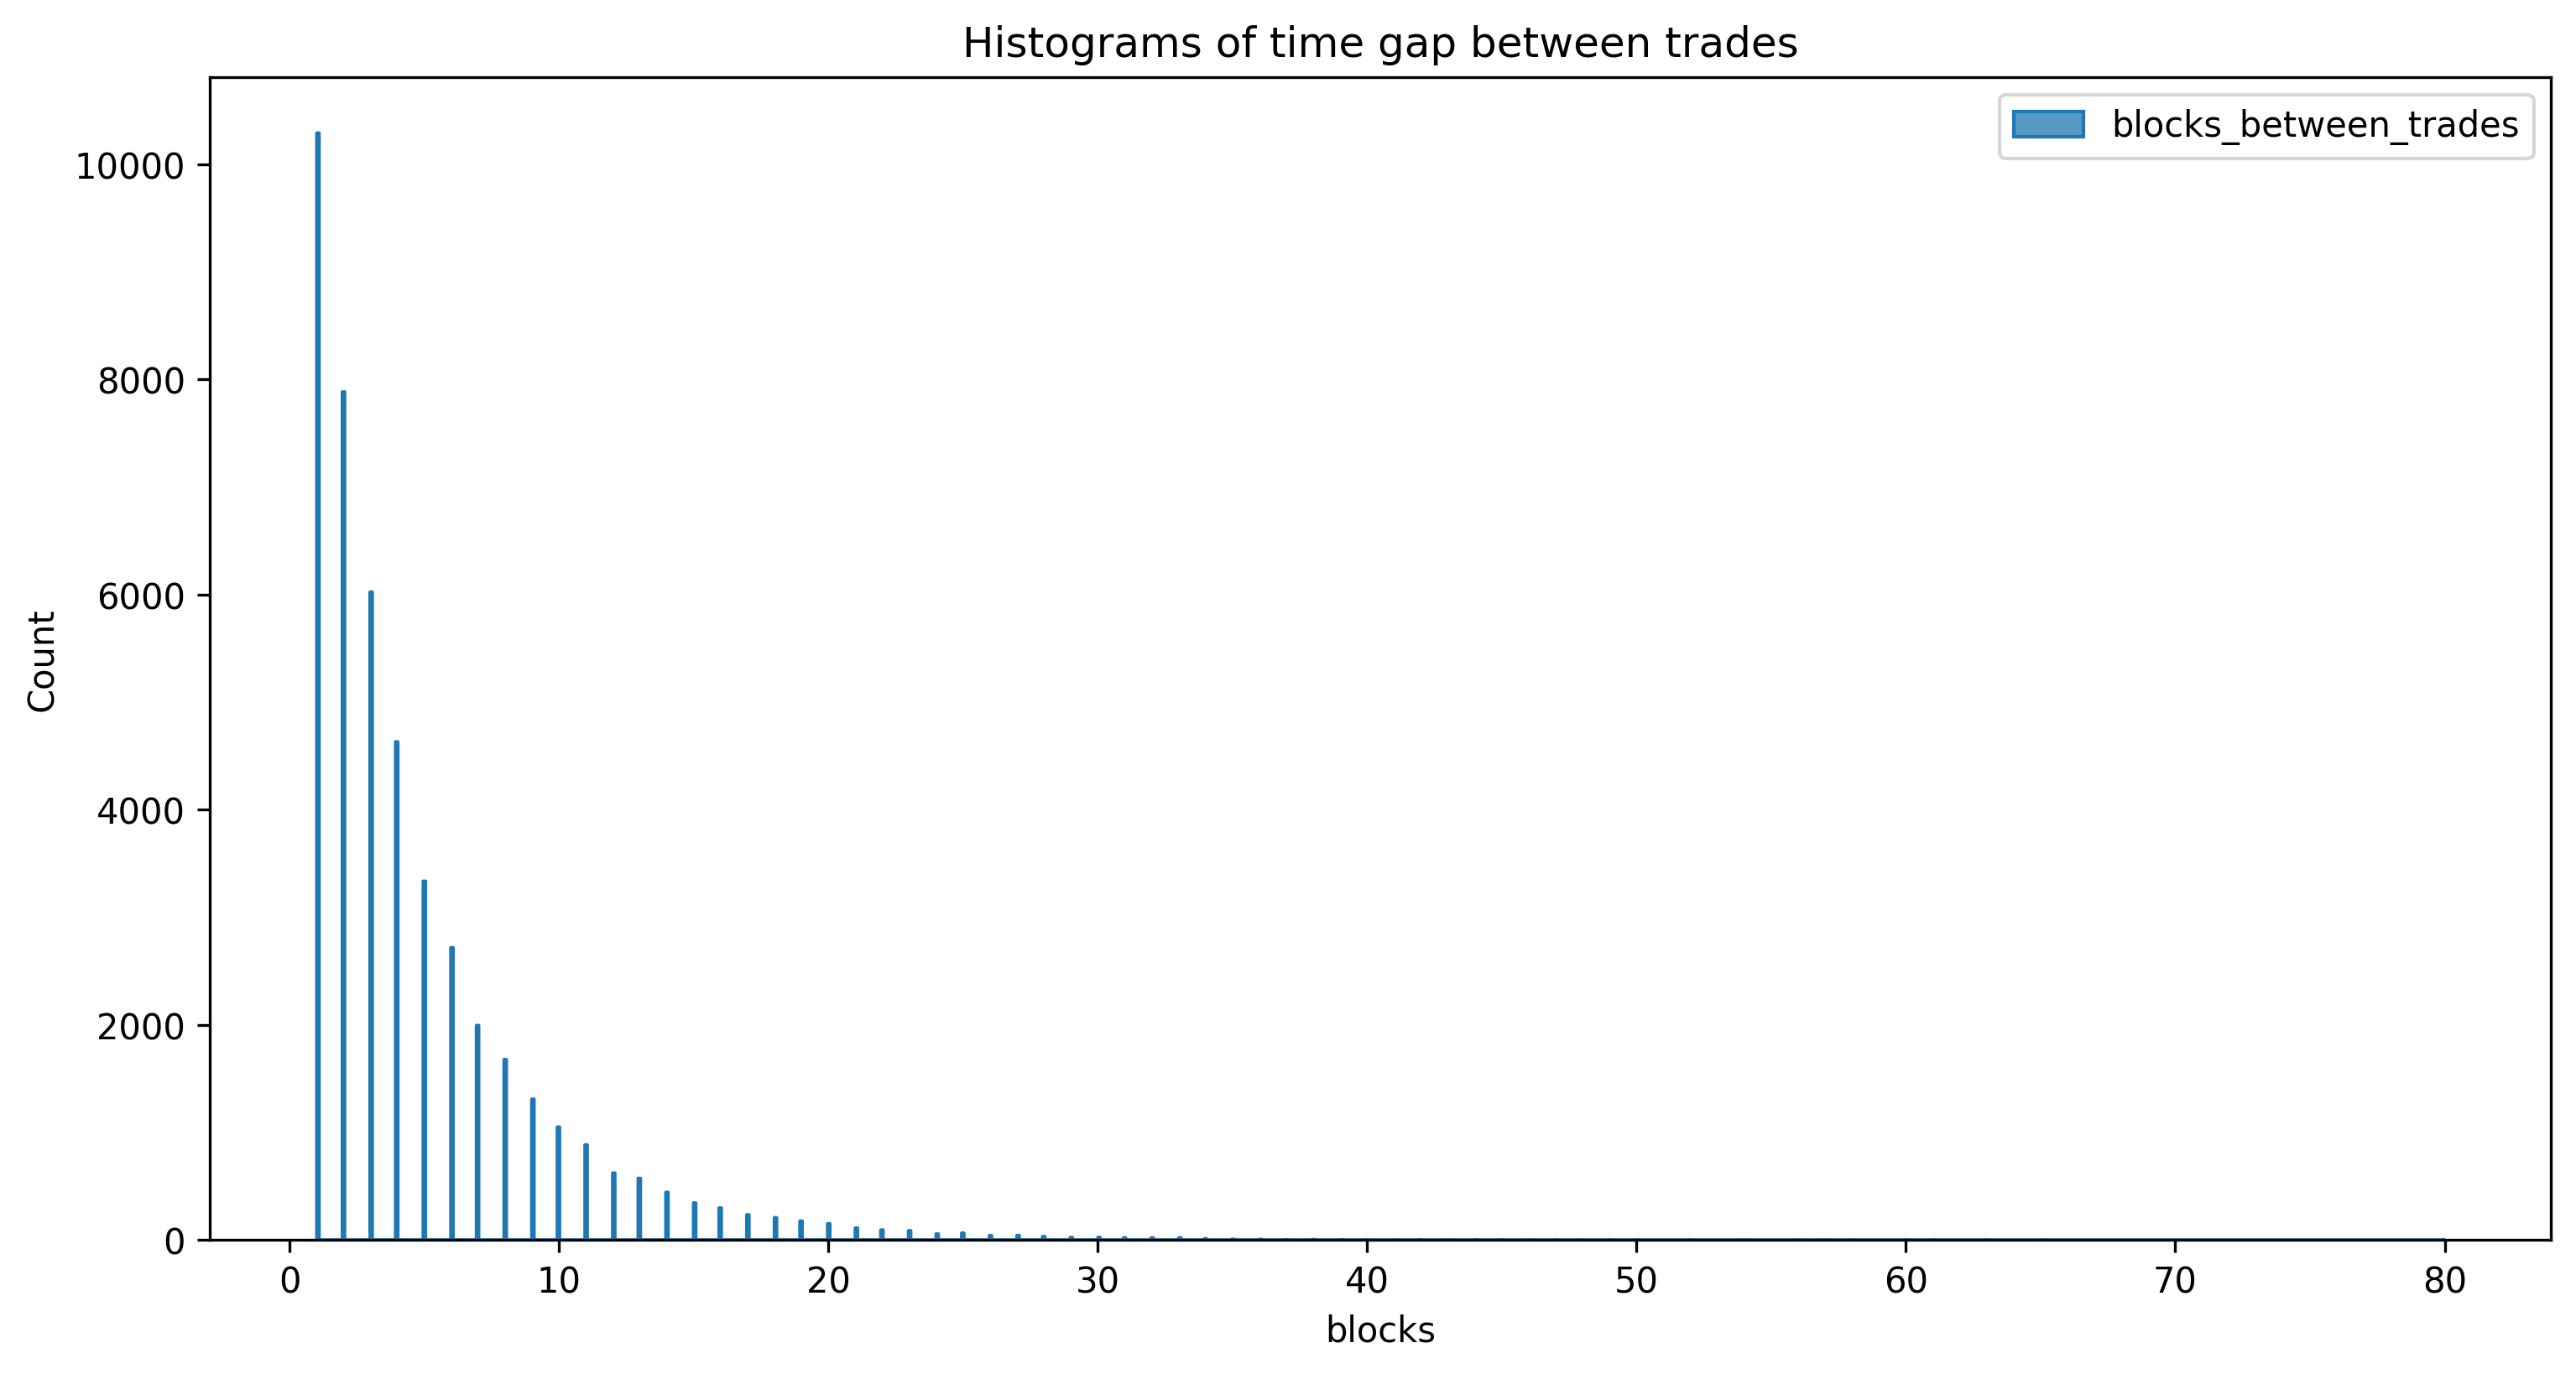

In [26]:
"""
Arrival rates of swaps
"""
blocks_between_trades = blocks_with_trades.index.to_list()
gap = []
for i in range(1, len(blocks_between_trades)):
    gap.append(blocks_between_trades[i] - blocks_between_trades[i - 1])

plt.figure(figsize=(12, 6), dpi=300)
sns.histplot(gap, bins=1000, label="blocks_between_trades", element="step")

plt.xlabel("blocks")
plt.ylabel("Count")
plt.title("Histograms of time gap between trades")
plt.legend()

plt.show()

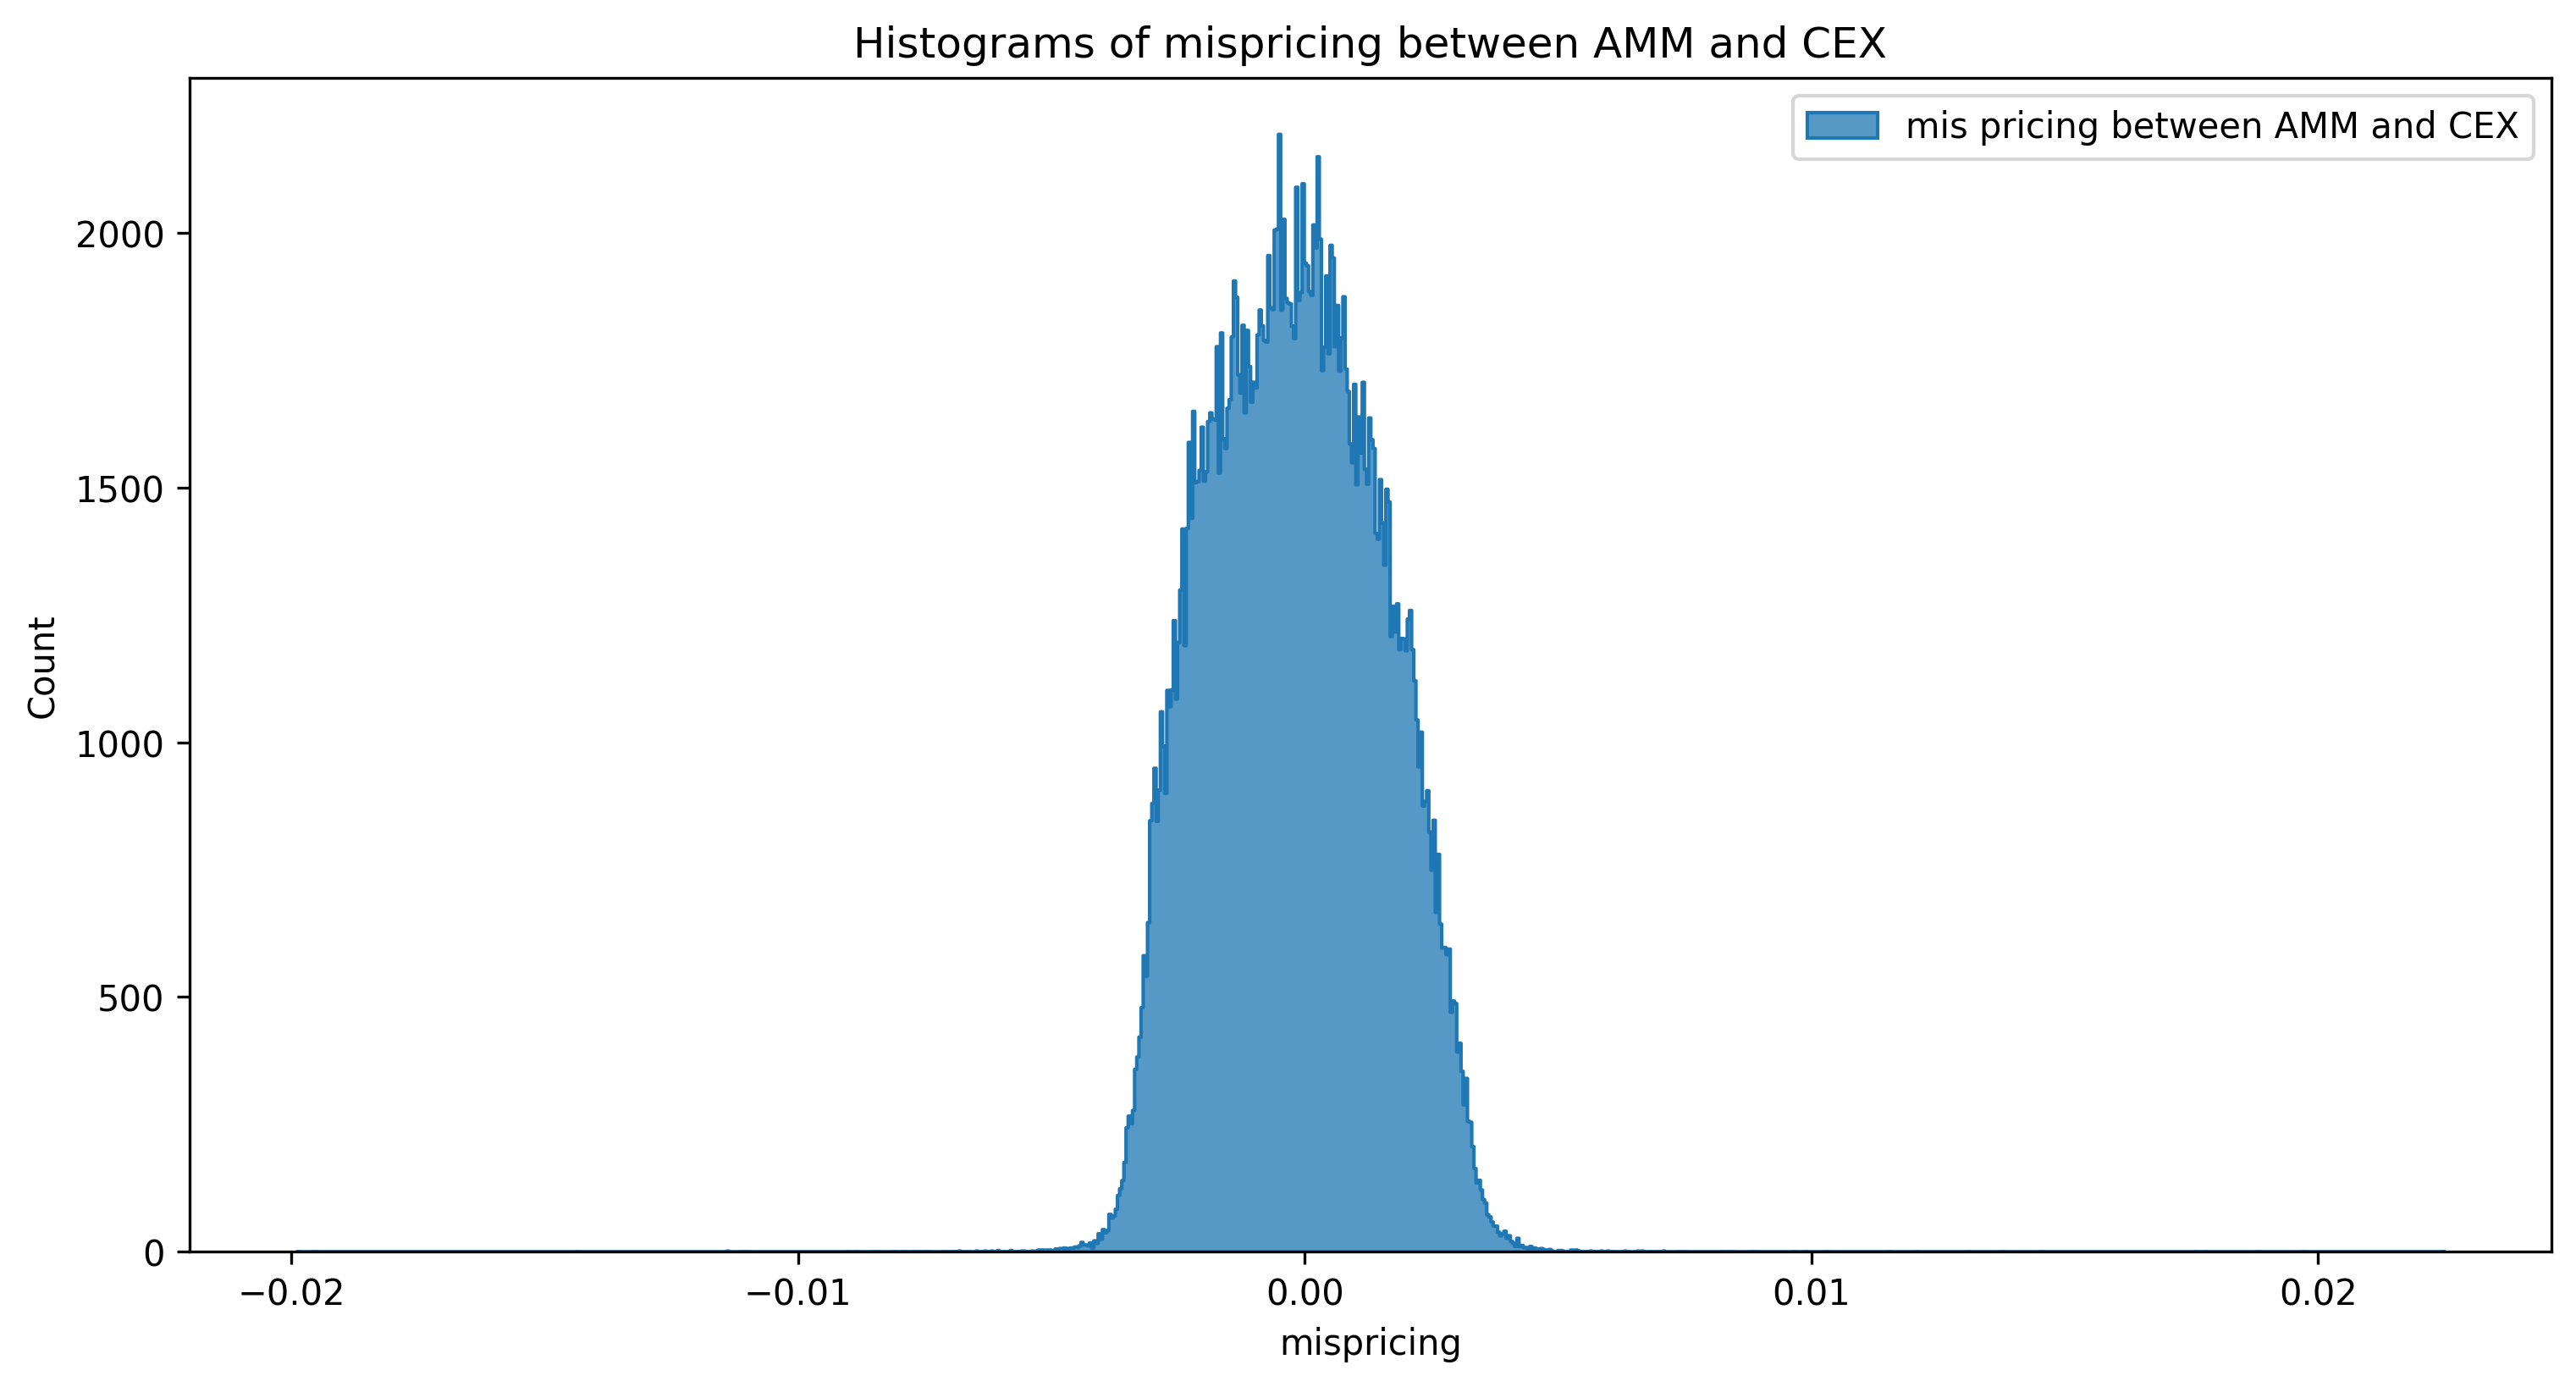

In [30]:
"""
Mispricing distribution
"""
df["amm_price"] = df["reserve0"] / df["reserve1"]
df["misPricing"] = np.log(
    df["price"] / df["amm_price"].shift(1)
)  # We want to know the gap before arbitrageurs fix it.

plt.figure(figsize=(12, 6), dpi=300)
sns.histplot(
    df["misPricing"], bins=1000, label="mis pricing between AMM and CEX", element="step"
)

plt.xlabel("mispricing")
plt.ylabel("Count")
plt.title("Histograms of mispricing between AMM and CEX")
plt.legend()

plt.show()

In [ ]:
"""
TODO: 
traderPnL per swap size
More Pair: especially Meme coins (PEPE, SHIB, MEME, APE)
More DEX (V3, Bal, Crv, LLAMMA)
comparison with L2
"""